# Домашнее задание 3. Алгоритмы кластеризации

Основная задача этого задания -- реализация одного из алгоритмов кластеризации. Кроме того, мы научимся подбирать параметры алгоритма, визуализируем результат кластеризации и попытаемся проанализировать природу полученных кластеров.

In [1]:
import pandas as pd
import pylab as pl
import numpy as np
import scipy.spatial as ss
import sklearn.cluster as sc
import sklearn.manifold as sm
import sklearn.datasets as ds
import sklearn.metrics as smt

# Plotting config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Cчитываем данные, полученные в результате выполнения предыдущего домашнего задания, в `data frame` библиотеки `pandas`. Конвертируем данные в массив `numpy`.

In [2]:
data_df = pd.read_csv("hw2_out.csv", sep="\t", header=0, index_col="uid")
x = data_df.values

Алгоритм кластеризации, который необходимо реализовать, выбирается на основании Вашего логина на портале Техносферы. При проверке домашнего задания бадут осуществляться проверка логина и соответствующего алгоритма.

In [5]:
algorithms = [
    u"Gaussian Mixture Model с использованием maximum a-posteriori для выбора кластера (параметр - k)",
    u"Hierarchical clustering с поддержкой single-linkage, complete-linkage, average-linkage (параметры - k, linkage)",
    u"DBSCAN. (параметры  - epsilon, min_pts)", 
    u"OPTICS. (параметры - epsilon, min_pts)"
]

my_algorithm = algorithms[hash("rom.holin") % len(algorithms)]
print u"Реализуем алгоритм кластеризации '%s'" % my_algorithm

Реализуем алгоритм кластеризации 'Hierarchical clustering с поддержкой single-linkage, complete-linkage, average-linkage (параметры - k, linkage)'


Алгоритм кластеризации должен удовлетворять следующему интерфейсу. Конструктор принимает набор параметров, необходимых для работы алгоритма кластеризации. Метод `fit` подсчитывает параметры модели и возвращает `self`. Метод `predict` возвращает вектор с индексами кластеров для поданных в него объектов `x`

In [6]:
import random
from heapq import heappush, heappop

class Clustering:
    """
    Implement clustering algorithm according 
    """    
    def __init__(self, data, linkage = None):
        """
        Please add necessary algoritm parameters to class constructor.
        """
        
        self.K1 = 20
        self.K2 = 20
        self.delta = 0
        self.data = data
        self.p_q = []
        self.used = [0 for i in xrange(2 * len(data) - 1)]
        self.in_queue = []
        self.linkage = linkage
        self.d = [[0 for j in xrange(2 * len(data) - 1)] for i in xrange(2 * len(data) - 1)]
        for i, x in enumerate(data):
            for j, y in enumerate(data):
                self.d[i][j] = self.dist(x, y)
        self.cluster = []
        self.construct()
        random.seed()
        self.result = [0 for i in xrange(len(data))]
        
        return
    
    def dist(self, x, y):
        ans = 0
        for i in xrange(len(x)):
            ans += (x[i] - y[i]) ** 2
        return ans
    
    def dist_cluster(self, v, x, y):
        return min(self.d[v][x], self.d[v][y])
    
    def new_dist(self, v, x, y):
        for i in self.in_queue:
            temp = self.dist_cluster(i, x, y)
            self.d[v][i] = temp
            self.d[i][v] = temp
        return
    
    def update_delta_set(self, v):
        for i in self.in_queue:
            if i != v and self.d[v][i] <= self.delta:
                heappush(self.p_q, (self.d[v][i], v, i))
        return
        
    def gen_delta(self):
        if len(self.in_queue) <= self.K2:
            #print "GEN DELTA SET A"
            self.dela = inf
            for i in self.in_queue:
                for j in self.in_queue:
                    if i != j:
                        heappush(self.p_q, (self.d[i][j], i, j))
            self.delta = inf
        else:
            #print "GEN DELTA SET B"
            ans = inf
            for time in xrange(self.K2):
                i = self.in_queue[random.randint(0, len(self.in_queue) - 1)]
                j = self.in_queue[random.randint(0, len(self.in_queue) - 1)]
                if i != j and self.d[i][j] < ans:
                    ans = self.d[i][j]
            self.delta = ans
            for i in self.in_queue:
                self.update_delta_set(i)
        return
                    
    
    def construct(self):
        self.cluster = [[i] for i in xrange(len(self.data))]
        self.in_queue = [i for i in xrange(len(self.data))]
        for time in xrange(len(self.data) - 1):
            c_a = 0
            c_b = 0
            #d1 = 0
            f = False
            #print len(self.p_q)
            while (len(self.p_q) > 0 and not f):
                t = heappop(self.p_q)
                if not self.used[t[1]] and not self.used[t[2]]:
                    #d1 = t[0]
                    c_a = t[1]
                    c_b = t[2]
                    f = True
            #print len(self.p_q)
            if not f:
                self.gen_delta()
                #print len(self.p_q)
                f = False
                while (len(self.p_q) > 0 and not f):
                    t = heappop(self.p_q)
                    #print t
                    if not self.used[t[1]] and not self.used[t[2]]:
                        #d1 = t[0]
                        c_a = t[1]
                        c_b = t[2]
                        f = True
            
            self.cluster.append([c_a, c_b])
            #print len(self.p_q)
            #print time, "delta = ", self.delta, "d1 = ", d1, c_a, c_b
            self.in_queue.remove(c_a)
            self.in_queue.remove(c_b)
            self.in_queue.append(len(self.cluster) - 1)
            self.used[c_a] = True
            self.used[c_b] = True
            self.new_dist(len(self.cluster) - 1, c_a, c_b)
            self.update_delta_set(len(self.cluster) - 1)
        return
    
    def dfs(self, i, v):
        if v < len(self.result):
            self.result[v] = i
        if (len(self.cluster[v]) != 1):
            self.dfs(i, self.cluster[v][0])
            self.dfs(i, self.cluster[v][1])
        return
    
    def predict(self, k):
        l = len(self.cluster) - 1
        #print l
        cluster = []
        cluster.append(l)
        for time in xrange(k - 1):
            cluster.append(self.cluster[l][0])
            cluster.append(self.cluster[l][1])
            #print l, self.cluster[l][0], self.cluster[l][1]
            cluster.remove(l);
            l = l - 1
        #print cluster
        for i, l in enumerate(cluster):
            self.dfs(i, l)
        return self.result
    
    def quality(self, k):
        l = len(self.cluster) - 1
        cluster = []
        cluster.append(l)
        answer = []
        cluster.append(self.cluster[l])
        for time in xrange(k - 1):
            #print self.d[self.cluster[l][0]][self.cluster[l][1]]
            answer.append(self.d[self.cluster[l][0]][self.cluster[l][1]])
            #print l, self.cluster[l][0], self.cluster[l][1]
            cluster.append(self.cluster[l][0])
            cluster.append(self.cluster[l][1])
            cluster.remove(l);
            l = l - 1
        return answer
    
    def fit_predict(self, k):
        return self.predict(k)

/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


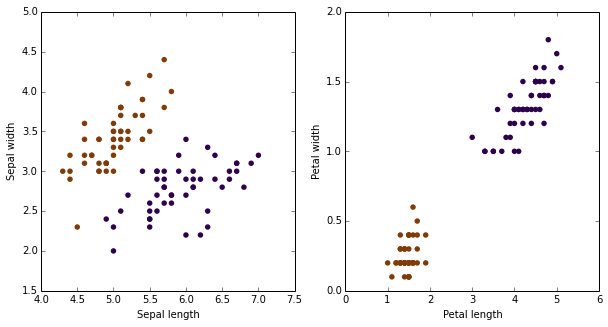

In [7]:
iris = ds.load_iris()
x_iris = iris.data[:100]
y_iris = iris.target[:100]

pl.figure(figsize=(10, 5))

pl.subplot(1, 2, 1)
pl.scatter(x_iris[:, 0], x_iris[:, 1], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

pl.subplot(1, 2, 2)
pl.scatter(x_iris[:, 2], x_iris[:, 3], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Petal length')
plt.ylabel('Petal width')
pl.show()

Видно, что классы разделяются, поэтому можно надеяться, что наш алгоритм "найдет" кластеры, соответствующие исходным классам. Результат работы реализованного алгоритма кластеризации предлагается сравнить с эталонной кластеризацией. Для этого предлагается изучить метрику ([adjusted rand score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html)). В случае если значение этой метрики отличается от 1, предлагается поработать над улучшением реализации своего алгоритма.

In [8]:
pred_iris = Clustering(x_iris).fit_predict(2)
#for i, j in enumerate(pred_iris):
    #print i, j
print "Adjusted Rand index for iris is: %.2f" % smt.adjusted_rand_score(y_iris, pred_iris)
print y_iris
print pred_iris

Adjusted Rand index for iris is: 1.00
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


/usr/local/lib/python2.7/dist-packages/numpy/core/fromnumeric.py:2652: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  VisibleDeprecationWarning)


Выбрать и реализовать критерий качества, на основании которого будут подбираться параметры модели. Варианты критериев:
- Инерция (сумма квадратов расстояний от каждой из точек до ближайшего к этой точке центроида)
- Средний диаметр (максимальное расстояние между точками в кластере) или радиус (расстояние от центроида до самой дальней от него точки в кластере)
- Sihouette

**Критерий качества необходимо выбрать таким образом, чтобы он подходил для реализованного алгоритма**

In [9]:
def quality(x, y):
    """
    Implement quality criterion of your choice
    """
    return 0.51

Применим критерий для выбора параметров алгоритма. Предлагается изменить следующий код таким образом, чтобы кластеризация вызывалась с верным набором параметров. На графике можно будет увидеть зависимость критерия от параметров алгоритма. Необходимо выбрать оптимальные значения этих параметров.

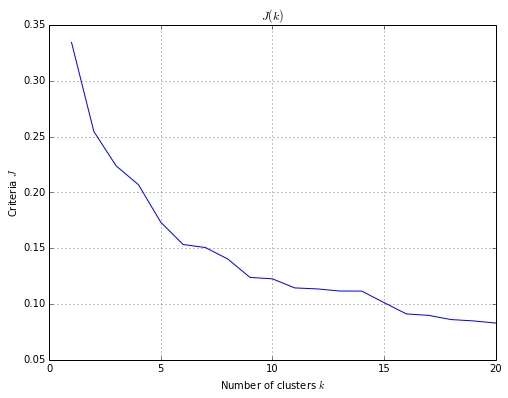

In [10]:
ks = range(1, 21)
#criteria = np.zeros(len(ks))
cls =  Clustering(x[:5000])
criteria = cls.quality(21)

#for i, k in enumerate(ks):
    #y = cls.fit_predict(k)
    #criteria[i] = quality(x, y)

#print answer
pl.figure(figsize=(8, 6))
pl.plot(ks, criteria)
pl.title("$J(k)$")
pl.ylabel("Criteria $J$")
pl.xlabel("Number of clusters $k$")
pl.grid()
pl.show()

Далее необходимо кластеризовать данные, используя выбранное количество кластеров, и визуализировать результат с помощью T-SNE. Внимание! На полном объеме данных данный алгоритм может работать существенное время. 

In [11]:
k = 11
#cls1 = Clustering(x[:1000])
y = cls.fit_predict(k)
#print y

Визуализируем результаты кластеризации ([подсказка](http://anokhin.github.io/img/hw3_tsne-kmeans.png)). Можно ли сказать, что в двумерном пространстве объекты из одного кластера находятся недалеко? Какой вывод можно сделать о качестве кластеризации?

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.077188
[t-SNE] Error after 100 iterations with early exaggeration: 1.629575
[t-SNE] Error after 325 iterations: 1.463196


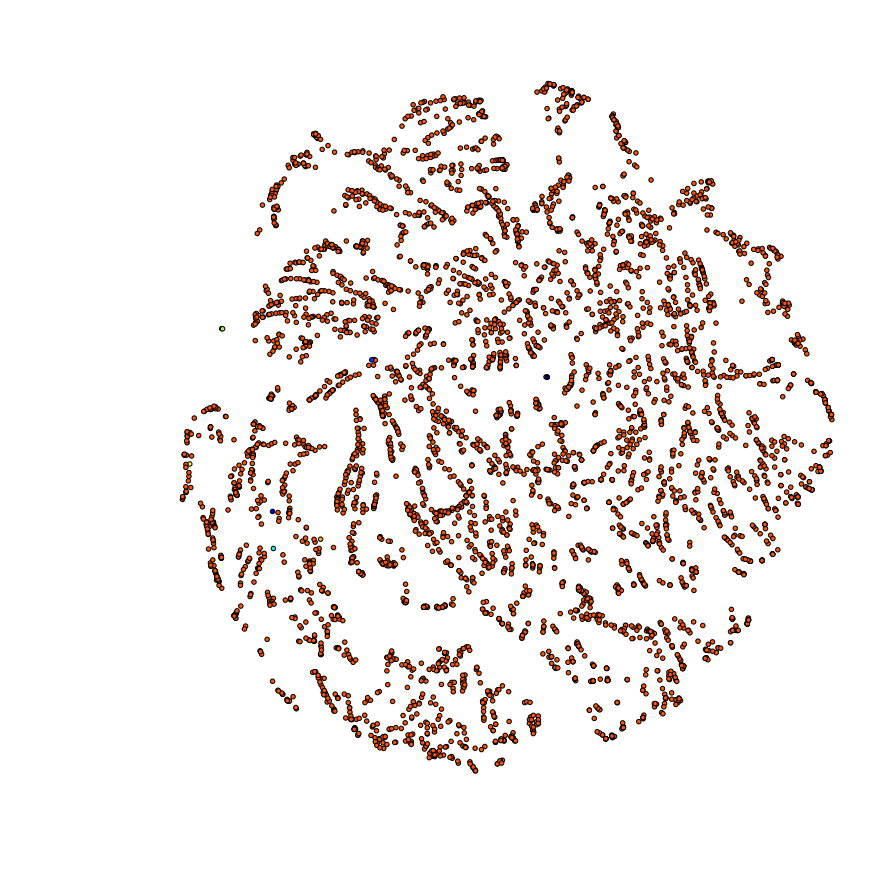

In [12]:
tsne = sm.TSNE(n_components=2, verbose=1, n_iter=1000)
z = tsne.fit_transform(x[:5000])

# Color map
cm = pl.get_cmap('jet')
pl.figure(figsize=(15, 15))
pl.scatter(z[:, 0], z[:, 1], c=map(lambda c: cm(1.0 * c / k), y))
pl.axis('off')
pl.show()

Попробуем проанализировать полученные кластеры. Для того, чтобы интерпретировать "суть" каждого из кластеров, построим [radar plot](http://www.wikiwand.com/en/Radar_chart), отображающий их центроиды. Посмотрите на графики и попробуйте объяснить, каким поведением можно охарактеризовать каждый из полученных кластеров? Есть ли среди кластеров похожие?

Реализация радара позаимствована отсюда: 
http://www.science-emergence.com/Matplotlib/MatplotlibGallery/RadarChartMatplotlibRougier/

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:49: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 11437 but corresponding boolean dimension is 5000


IndexError: index out of range

/usr/lib/pymodules/python2.7/matplotlib/cbook.py:1711: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  result = np.zeros(new_shape, a.dtype)


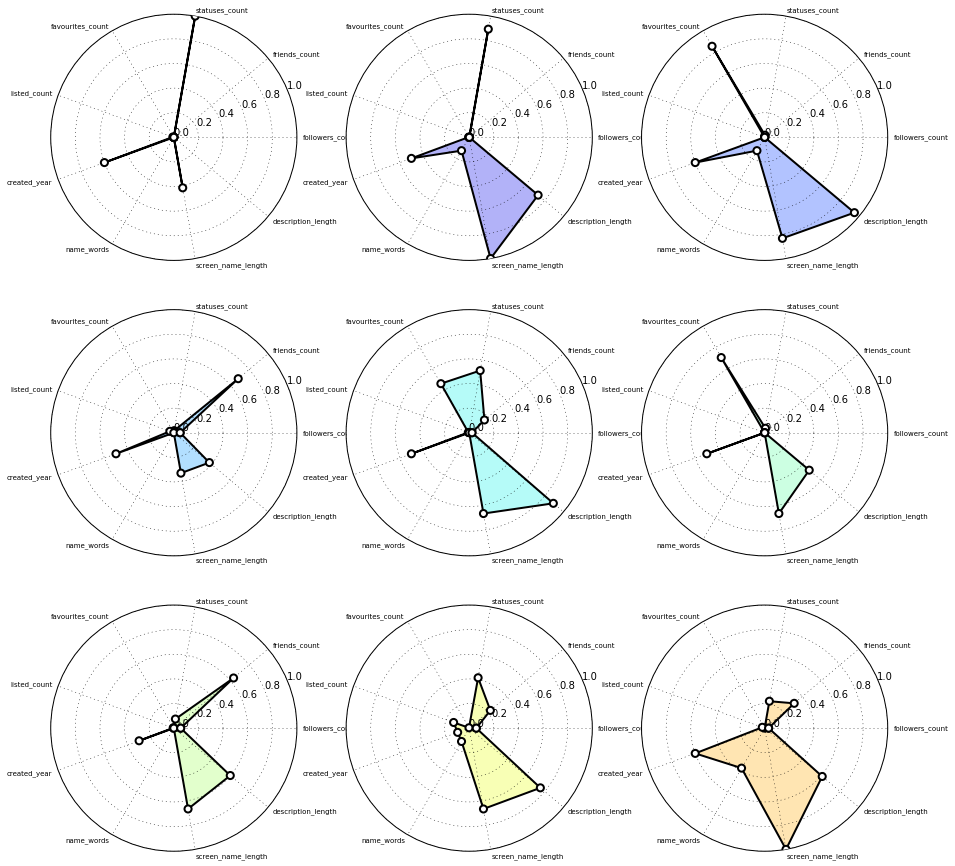

In [13]:
def radar(centroid, features, axes, color):
    # Set ticks to the number of features (in radians)
    t = np.arange(0, 2*np.pi, 2*np.pi/len(features))
    plt.xticks(t, [])

    # Set yticks from 0 to 1
    plt.yticks(np.linspace(0, 1, 6))

    # Draw polygon representing centroid
    points = [(x, y) for x, y in zip(t, centroid)]
    points.append(points[0])
    points = np.array(points)
    codes = [path.Path.MOVETO,] + [path.Path.LINETO,] * (len(centroid) - 1) + [ path.Path.CLOSEPOLY ]
    _path = path.Path(points, codes)
    _patch = patches.PathPatch(_path, fill=True, color=color, linewidth=0, alpha=.3)
    axes.add_patch(_patch)
    _patch = patches.PathPatch(_path, fill=False, linewidth = 2)
    axes.add_patch(_patch)

    # Draw circles at value points
    plt.scatter(points[:,0], points[:,1], linewidth=2, s=50, color='white', edgecolor='black', zorder=10)

    # Set axes limits
    plt.ylim(0, 1)

    # Draw ytick labels to make sure they fit properly
    for i in range(len(features)):
        angle_rad = i/float(len(features))*2*np.pi
        angle_deg = i/float(len(features))*360
        ha = "right"
        if angle_rad < np.pi/2 or angle_rad > 3*np.pi/2: ha = "left"
        plt.text(angle_rad, 1.05, features[i], size=7, horizontalalignment=ha, verticalalignment="center")

# Some additiola imports
import matplotlib
import matplotlib.path as path
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Choose some nice colors
matplotlib.rc('axes', facecolor = 'white')
# Make figure background the same colors as axes 
fig = plt.figure(figsize=(15, 15), facecolor='white')

cm = pl.get_cmap('jet')

clusters = np.unique(y)
for j, cluster in enumerate(clusters):    
    x_c = x[y == cluster]
    centroid = x_c.mean(axis=0)    
    # Use a polar axes
    axes = plt.subplot(3, 3, j + 1, polar=True)
    radar(centroid, data_df.columns.values, axes, cm(1.0 * j / k))

plt.show()

Поздравляем, Вы завершили домашние задания по модулю "Алгоритмы кластеризации". Надеемся, что это было интересно.